## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error
%matplotlib inline


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that reference data
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))

    return data_fls, ref_fls


def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']

    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability.

    Args:
        pr_errors: array of errors between pulse rate and references.
        confidence_est:array of confidence estimates for pulse rate error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estim0tes = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error

    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)

    return AggregateErrorMetric(errs, confs)


def windowned_split(signal, fs, time_wind=8, overlap=6):
    """
    Function to create subsets of signals using windows of specific duration

    Usage:
        signal: singal from which are generated the subsets
        fs: sampling frequency
        time_wind: length of the time window
        overlap: overlap between windows

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
    """

    windows = []
    for n in range(0, fs*signal.shape[0], ((time_wind-overlap)*fs)):
        if len(signal[n:n+(time_wind)*fs]) == (time_wind*fs):
            windows.append(signal[n:n+(time_wind)*fs])

    return windows


def Feats_df(GTruth, PPGs_feat):
    """
    Function that creates dataframe containing features the ground truth

    Usage:
        GTruth: List containing the real users heart rates
        PPGs_feat: List containing users features

    Returns:
        df: Dictionary containing the users features and their real heartrates
    """

    feat = []
    ref = []
    subjects = []
    for n in range(12):
        for x, y in zip(PPGs_feat[n], GTruth[n]):
            ref.append(y[0])
            feat.append(x)
            subjects.append(n+1)

    data_dict = {}

    for n in range(np.array(feat).T.shape[0]):
        data_dict['subject'] = subjects
        data_dict['feat'+str(n)] = np.array(feat).T[n]

    data_dict['HR'] = ref

    return pd.DataFrame(data_dict)


def Train_Regressor(data, ref, fs, Nf=5, twin=8, ove=6, lof=40/60, hif=240/60):
    """
    Function to train the model used to estimate the users heartrates

    Usage:
        data_fls: filename containing the users signals
        ref_fls: filename containing the ground truth for the user heart rate
        fs: sampling frequency
        N_feat: number of frequencies to use as features
        time_wind: length of the time window
        overlap: overlap between windows
        low_cutf: low cutting frequency
        hi_cutf: high cutting frequency

    Returns:
        clf: Trained Randomforest regressor model
    """
    GTruth = []
    ACCs_feat = []
    PPGs_feat = []
    Subjects = []

    for dat, ref in zip(data, ref):

        GTruth.append(sp.io.loadmat(ref)['BPM0'])
        ppg, accx, accy, accz = LoadTroikaDataFile(dat)
        hs_n, hs_d = signal.butter(3, (lof, hif), 'bandpass', fs=fs)
        accs = [accx, accy, accz]
        Features, signals, spectrums = Preprocessing(ppg, accs, fs, Nf=Nf)
        PPGs_feat.append(Features)

    df = Feats_df(GTruth, PPGs_feat)

    clf = Regressor_HR()

    X = df[df.columns[1:(Nf*2)+1]].values
    y = df.HR.values

    clf.fit(X, y)

    return clf


def Preprocessing(ppg, accs, fs, Nf=5, twin=8, over=6, lof=40/60, hif=240/60):
    """
    Retrieve that find features to estimate the users heart rates

    Usage:
        ppg: time series related to the ppg sensor
        accx: time series related to the acceelerometer of the x axis
        accy: time series related to the acceelerometer of the y axis
        accz: time series related to the acceelerometer of the z axis
        fs: sampling frequency
        N_feat: number of frequencies to use as features
        time_wind: length of the time window
        overlap: overlap between windows
        low_cutf: low cutting frequency
        hi_cutf: high cutting frequency

    Returns:
        PPGs: Features generated from the PPG signals
        signals: Time series related to the windows of the ppg signal
        spectrums: Spectrum related to the windows of the ppg signal
    """

    accx, accy, accz = accs[0], accs[1], accs[2]

    # plt.plot(ppg)
    ppg = (ppg - ppg.mean())

    # Estimating the frequency domain representation
    ppg_windows = windowned_split(ppg, fs, twin, over)
    accx_windows = windowned_split(accx, fs, twin, over)
    accy_windows = windowned_split(accy, fs, twin, over)
    accz_windows = windowned_split(accz, fs, twin, over)

    # Defining the band pass filter
    hs_n, hs_d = signal.butter(3, (lof,  hif), 'bandpass', fs=fs)

    #
    PPGs_feat = []
    ACCs_feat = []
    signals = []
    spectrums = []

    for n in range(len(ppg_windows)):

        accx_w = sp.signal.filtfilt(hs_n, hs_d, accx_windows[n])
        accy_w = sp.signal.filtfilt(hs_n, hs_d, accy_windows[n])
        accz_w = sp.signal.filtfilt(hs_n, hs_d, accz_windows[n])
        acc_w = np.array(np.sqrt(accx_w**2+accy_w**2+accz_w**2))
        ppg_window = sp.signal.filtfilt(hs_n, hs_d, ppg_windows[n])
        signals.append(ppg_window)

        from numpy.fft import rfftfreq
        acc_freq = rfftfreq(len(acc_w), 1/fs), np.abs(np.fft.rfft(acc_w))
        acc_freq[1][(acc_freq[0] >= lof) & (acc_freq[0] <= hif)]
        acc_pks = sp.signal.find_peaks(acc_freq[1], height=10, distance=5)[0]

        temp = np.fft.rfft(ppg_window)
        ppg_freq = rfftfreq(len(ppg_window), 1/fs), np.abs(temp)
        ppg_freq[1][(ppg_freq[0] >= lof) & (ppg_freq[0] <= hif)]
        pks = sp.signal.find_peaks(ppg_freq[1], height=100, distance=10)[0]
        temp = (ppg_freq[1][pks].max()) == ppg_freq[1][pks]
        ppg_freq_max = ppg_freq[0][pks][temp]
        spectrums.append(ppg_freq)

        PPGs_feat.append(ppg_freq[0][[ppg_freq[1].argsort()[-Nf:][::-1]]])
        ACCs_feat.append(acc_freq[0][[acc_freq[1].argsort()[-Nf:][::-1]]])

    Feat = [np.concatenate([x, y]) for x, y in zip(PPGs_feat, ACCs_feat)]

    return Feat, signals, spectrums


def Regressor_HR():
    """
    Function that generates a randomforest model as a regressor

    Returns:
        clf: Randomforest regressor model
    """
    # Hyperparameters
    n_estimators = 400
    max_tree_depth = 20

    # Model
    ne = n_estimators
    md = max_tree_depth

    clf = RandomForestRegressor(n_estimators=ne, max_depth=md, random_state=42)

    return clf


def RunPulseRateAlgorithm(data_fl, ref_fl):

    """
    Estimate heart rates

    Usage:
        data_fl: filename containing the users signals
        ref_fl: filename containing the ground truth for the user heart rate

    Returns:
        pr_err: List containing the errors of the predictions
        pr_conf: list containing the confidence of the predictions

    """

    # Interval variables
    fs = 125
    N_feat = 5

    # Loading the data from the users
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    data_train, ref_train = LoadTroikaDataset()

    # Getting features for the predictions
    accs = [accx, accy, accz]
    Features, signals, spectrums = Preprocessing(ppg, accs, fs=fs, Nf=N_feat)
    Features = np.array(Features)

    # Generating the model to find the heart rate
    clf = Train_Regressor(data_train, ref_train, fs=fs, Nf=N_feat)

    # Compute pulse rate estimates and estimation confidence
    pr_est = clf.predict(Features)
    pr_ref = sp.io.loadmat(ref_fl)['BPM0'].reshape(-1)

    # Finding metrics to measure the performance of the model
    pr_conf = []
    pr_err = []

    for n in range(len(signals)):

        freqs = spectrums[n][0]
        hr_f = pr_est[n]/60
        fft_mag = np.abs(spectrums[n][1])
        window_f = 5/60
        win1 = hr_f - window_f
        win2 = hr_f + window_f
        fundamental_freq_wind = (freqs > win1) & (freqs < win2)

        pr_conf.append(np.sum(fft_mag[fundamental_freq_wind])/np.sum(fft_mag))
        pr_err.append(np.abs((pr_est[n]-pr_ref[n])))

    # Visualizing results
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    Time = np.arange(8, len(pr_ref)*8+8, 8)
    factor = [n*6 for n in range(Time.shape[0])]
    Time = [x-y for x, y in zip(Time, factor)]

    ax[0].plot(Time, pr_est, label='PPG HR')
    ax[0].plot(Time, pr_ref, label='ECG HR')
    ax[0].set_ylabel('Heart rate [BPM]')
    ax[0].set_xlabel('Time [s]')
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(Time, pr_err, '.-r', label='Error')
    ax2 = ax[1].twinx()
    ax2.plot(Time, pr_conf, 'g--', label='Confidence')
    ax[1].set_ylabel('Error')
    ax2.set_ylabel('Confidence [Pred/Real]')
    ax[1].set_xlabel('Time [s]')
    ax[1].grid(True)

    ax[1].legend()
    ax2.legend()

    # Return per-estimate mean absolute error and confidence
    # ref_idx = np.cumsum(np.ones(len(ref)) * 125 * 2) - 125 * 2
    return pr_err, pr_conf


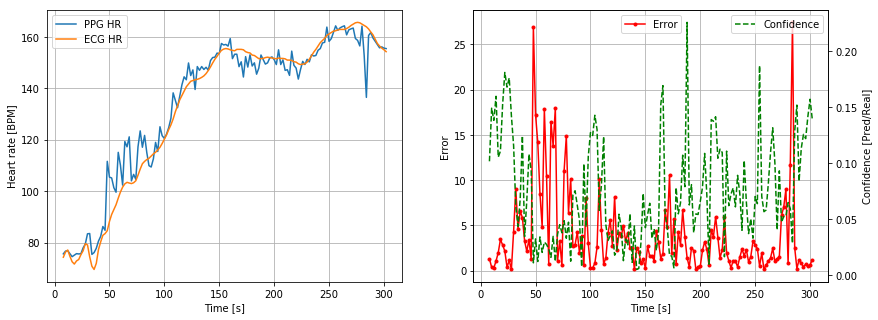

In [2]:
data_train, ref_train = LoadTroikaDataset()
Error, Confidence = RunPulseRateAlgorithm(data_train[0], ref_train[0])

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

### Code Description:

The implemented code was used to estimate the heart rate of users of wearable devices. This, by using the PPG and accelerometers of the device to estimate the heart rate frequency, relying on techniques such as the Welch periodograms, the Fourier transform and random forest ML algorithms. More information about the different techniques implemented in the code can be found in the code comments. The functionality of the code can be described with the following steps:

- Generating subsets of the signals of specific lengths
- Calculating the frequency components of the signals to be used as features
- Training an ML model using the features and the real heart rate of the users
- Obtaining the performance of the model estimating the user's heart rates

#### How to run the code:

The code can be run following the next steps:

- Provide the *RunPulseRateAlgorithm* function with the filenames of the users acquired PPG and accelerometers data, as well as the ECG signal used as ground truth of the user's heart rate. 

- The results given by the algorithm to the user are metrics of how well estimated were the rates given by the device that uses the developed technique. 

### Data Description:

The data used to estimate the user's heart rate was acquired from sensors of wearable devices, such as signals acquired from PPG sensors and accelerometers. However, other signals used as reference were provided such as an ECG signal. 

The PPG signal was used to find the main frequency related to the user's heart rate, while the accelerometers were used to reduce artefacts generated from the user's movements. Moreover, the ECG provided signal was used as a reference to determine how accurate was the provided estimations.

#### Data usage:

PPG signals were used to determine the user's heart rate by finding their main frequencies and using them as a reference. On the other hand, accelerometers signals were used to compensate for users movements while estimating their heart rates. Finally, the ECG provided signal was used as a reference to determine how accurate was the provided estimations.

#### Sensors used:

The device where the algorithm developed is going to be deployed is composed of PPG sensors capable of measuring the number of red blood cells passing through veins. In addition, the devices also contain accelerometers related to x, y and z-axis that gave us information about the user's movements. Lastly, an additional signal to the ones provided by the devices is given, from an arrangement of ECG sensors, which measure potentials generated by the heart. 

#### Amount of data

The data provided were acquired from 12 different users, from different runs of a specific experiment were the heart rate of the users varies accordingly with different conditions. The stimulus that the users experienced was related with specific heart rate provided as ground truth, were each of them can be measure from windows of 8 seconds lengths from the signals provided from the devices of interest. The data was sampled with a frequency of 125 Hz. 

#### Dataset short-comings

To build a more complete dataset it is required a more complete dataset in order to increase the robustness of the trained model. Furthermore, it is necessary to determine to which persons the use of the algorithm is used, for example, their age, the purchasing power, their gender, and similar characteristic that can help to increase the performance of the algorithm by being trained for a more specific population. 

### Algorithm description

#### Functionality

The algorithm works considering the physiological characteristics of the signals used for the estimation of the users heart rate. As mentioned before, the objective of the algorithm is to use the flow of red blood cells through the cardiovascular system to measure the frequency at those flows through a specific point, in our case those are measure by the PPG sensors. However, due to different artefacts introduced to the measured signals due to the user's movements, accelerometers signals that measure on the three different axis the user's movements, it is possible to reduce the noise added to the PPG sensor measurements. 

Thus, once the main frequency and the first 3 harmonics were obtained from the PPG acquired signal were estimated, they were used in combination with the provided ECG signal used as the real user's heart rate to train a supervised ML regressor. For this algorithm, a RandomForest was used as Regressor.

Once the RandomForest regressor is trained, it is possible to use the spectrum from any signal to determine the user's heart rate, accordingly with the dataset used to train the regressor.

#### Bias

The trained regressor tends to predict higher hear rates than the expected. This can be due to the scenario were the trained signals were acquired. Most of the heart rates used for the training of the algorithm are higher above 80 BPM, then the algorithm was trained to related PPG signals with those high rates rather be more balanced to less high heart rates.

####  Caveats on Algorithm Outputs

The algorithm-based its performance on the amount of power that is generated using the predicted HR in comparison with the amount of power that contains the original PPG signals acquired. Therefore, a higher confidence value means that both power are more similar, and then, it can be said that the found HR is closest to the real user HR. Nonetheless, the estimated HR can be affected by the presence of the user's movements, where the found frequency is affected by the accelerometers readings. As a result, the confidence of the algorithm decreases given that the power of the estimated signal generated by the HR is smaller than the generated from the PPG signal. 

#### Common failires mode

The algorithm does not have a good performance when the predicted HR frequency is similar to the cadence of the user's movements, or the frequency of the accelerometer. This because the algorithm can be given the frequency of the accelerometers reading rather than the HR from the PPG signals. 

### Algorithm Performance

The metric provides to show the performance of the algorithm is the mean absolute error of the estimation with respect to the provided users heart rates in the form of ECG signals. Additionally, a confidence metric was generated as the ratio between the recovery power using the estimated heart rates and the original PPG signal power, as explained before. Thus, the algorithm has a better performance when the mae is smaller and when the estimated confidence is closest to 1.

However, given the small number of users that generated the data for training the algorithm to estimate their HR, this can be biased toward specific characteristics of the users. Additional information is required to determine how robust is the implemented algorithm, such determining if the users are a representative sample of the users to which the device is focus or to more data from a bigger number of users. 



-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 